# Определение возраста покупателей

**Описание проекта:** Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- Контролировать добросовестность кассиров при продаже алкоголя

**Цель проекта:** Построить модель, которая по фотографии человека будет определять его возраст.

**Описание данных:** В моем распоряжении папка непосредственно с фотографиями, а также датасет с названием файла (фотографии) и точным возрастом человека на ней

**Ход проекта:**
- Исследовательский анализ
- Обучение нейронной сети и получение ее предсказаний
- Итоговые выводы

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

Приступим к исследовательскому анализу, подгрузим данные:

In [2]:
def upload_function(data, sep, decimal):
    try:
        info = pd.read_csv(f'/datasets/faces/{data}.csv', sep=sep, decimal=decimal)
    except: 
        info = pd.read_csv(f'https://code.s3.yandex.net/datasets/faces/{data}.csv', sep=sep, decimal=decimal)
    return info

In [3]:
labels = upload_function('labels', ',', ',')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим на размер выборки:

In [4]:
labels.shape

(7591, 2)

Имеем немного больше, чем семь с половиной тысяч фотографий. Взглянем на распределение возраста в выборке:

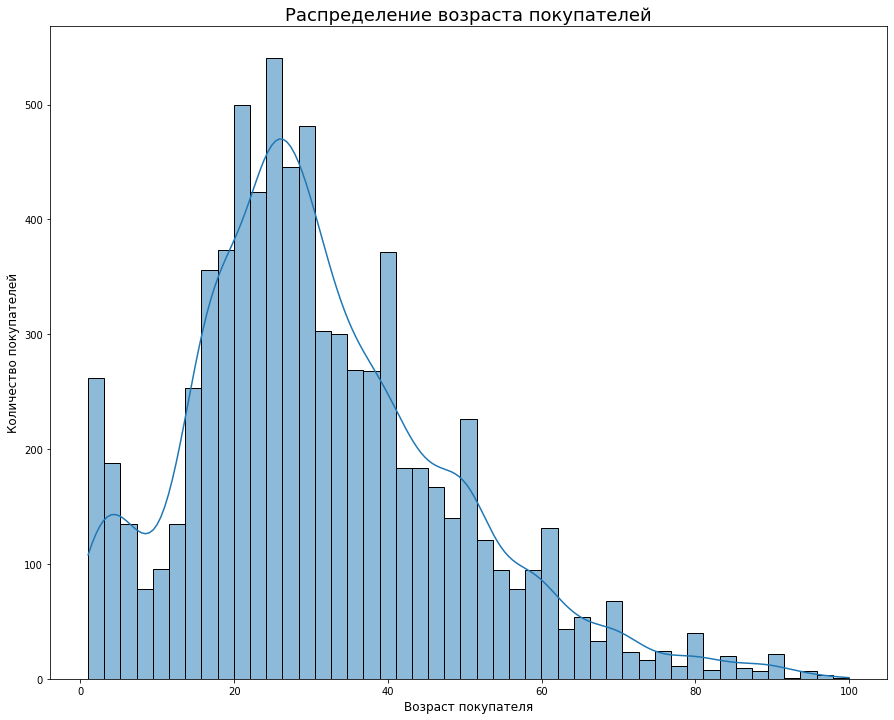

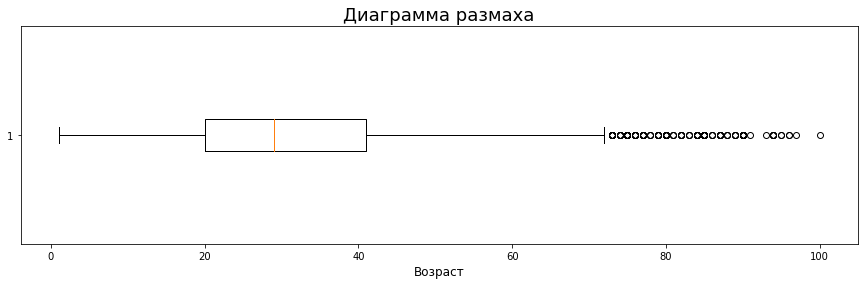

In [13]:
plt.figure(figsize=(15, 12))
plt.title('Распределение возраста покупателей', fontsize=18)
plt.xlabel('Возраст покупателя', fontsize=12)
plt.ylabel('Количество покупателей', fontsize=12)
sns.histplot(data=labels, x='real_age', kde=True)
plt.show()

plt.figure(figsize=(15, 4))
plt.title('Диаграмма размаха', fontsize=18)
plt.xlabel('Возраст', fontsize=12)
plt.boxplot(labels['real_age'], vert=False);

In [6]:
labels['real_age'].median()

29.0

Посмотрим на сами фотографии:

Found 7591 validated image filenames.


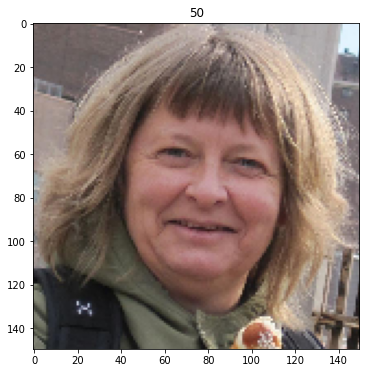

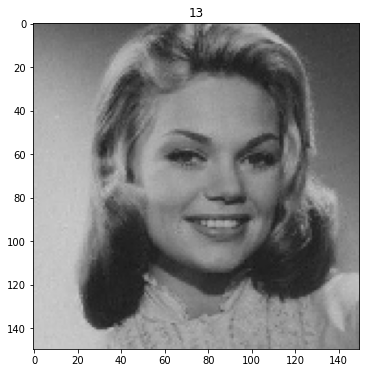

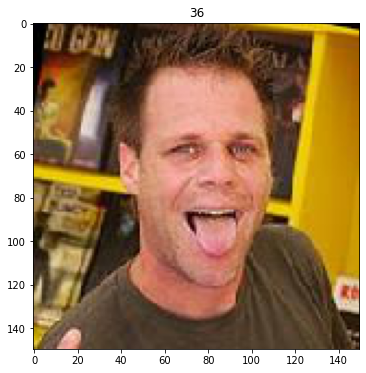

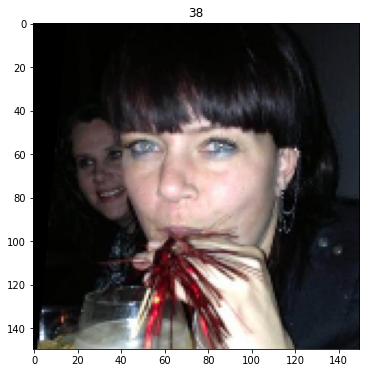

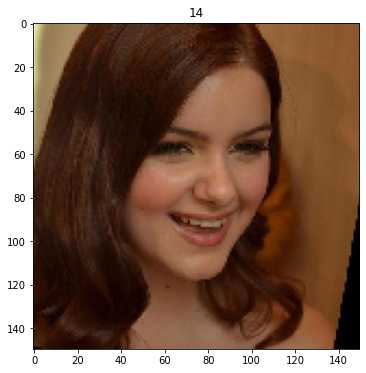

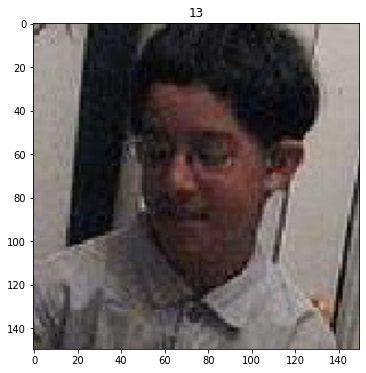

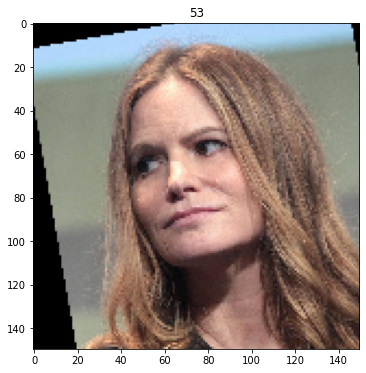

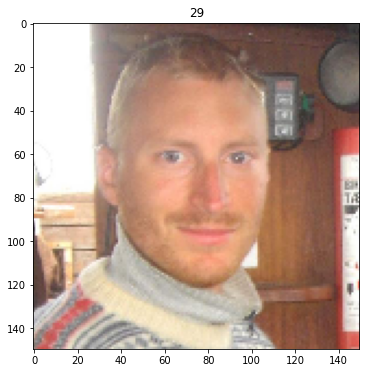

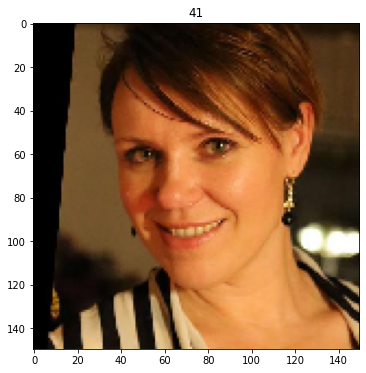

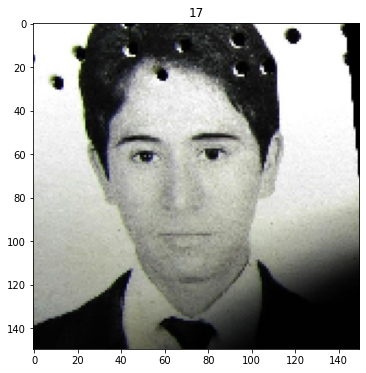

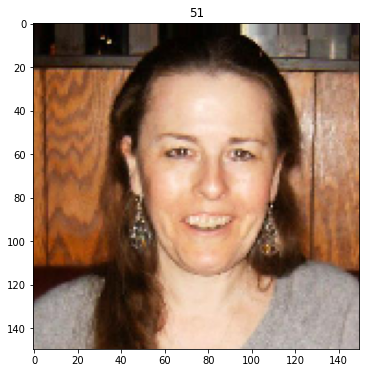

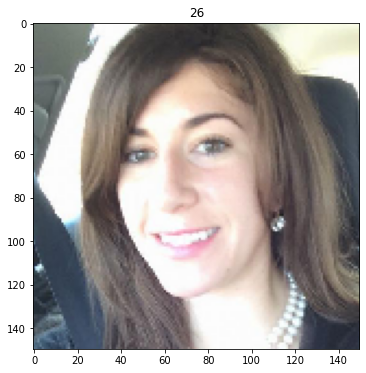

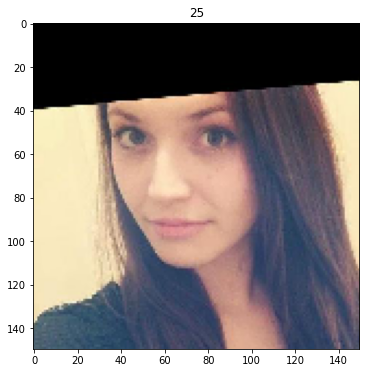

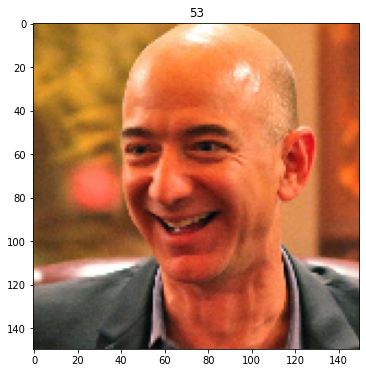

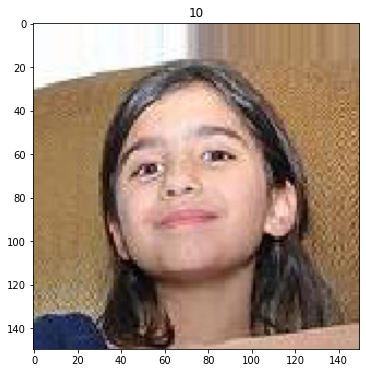

In [18]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_dataframe(dataframe=labels,
                                        directory='/datasets/faces/final_files',
                                        x_col='file_name',
                                        y_col='real_age',
                                       target_size=(150, 150),
                                        batch_size=15,
                                       class_mode='raw')

images, ages = next(generator)

for i in range(15):
    plt.figure(figsize=(6,6))
    plt.title(ages[i], fontsize=12)
    plt.imshow(images[i])
    plt.show()

**Промежуточные выводы:**

В датасете представлены люди практически всех возможных возрастов. Распределение возраста - чем-то схоже с нормальным, медианное значение - 29 лет. Нельзя не отметить, что присутствуют фотографии как детей, возрастом даже младше 6-8 лет, так и стариков возрастом более 85-90 лет, поэтому у нейроссети будет обширная выборка, на которой она обучится.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv') #CSV
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#        rotation_range=20,
#        width_shift_range=0.2,
#        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_data

def load_test(path): 
    labels = pd.read_csv(path + '/labels.csv') #CSV
    
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_data


def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    backbone.trainable = True  # РАЗМОРОЗИТЬ!
    
    # Строим модель
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  #регуляризация
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.0002)
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_model(model, train_data, test_data, batch_size=32, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

```

```


Решение
2025-10-28 15:26:01.448050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-10-28 15:26:01.450088: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-10-28 15:26:02.332477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-10-28 15:26:02.340932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-10-28 15:26:02.340990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-10-28 15:26:02.341021: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-10-28 15:26:02.342860: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-10-28 15:26:02.343215: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-10-28 15:26:02.345189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-10-28 15:26:02.346303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-10-28 15:26:02.346355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-10-28 15:26:02.348623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-10-28 15:26:02.518776: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-10-28 15:26:02.527315: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-10-28 15:26:02.528204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3f57cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-28 15:26:02.528227: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-10-28 15:26:02.704904: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5070300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-28 15:26:02.704941: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-10-28 15:26:02.706408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-10-28 15:26:02.706477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-10-28 15:26:02.706492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-10-28 15:26:02.706527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-10-28 15:26:02.706543: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-10-28 15:26:02.706558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-10-28 15:26:02.706573: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-10-28 15:26:02.706585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-10-28 15:26:02.709362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-10-28 15:26:02.709451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-10-28 15:26:03.134078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-10-28 15:26:03.134126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-10-28 15:26:03.134136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-10-28 15:26:03.136876: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-28 15:26:03.136930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 9s
  122880/94765736 [..............................] - ETA: 48s
  557056/94765736 [..............................] - ETA: 20s
 2113536/94765736 [..............................] - ETA: 7s 
 5636096/94765736 [>.............................] - ETA: 3s
10649600/94765736 [==>...........................] - ETA: 2s
13451264/94765736 [===>..........................] - ETA: 1s
14237696/94765736 [===>..........................] - ETA: 2s
18300928/94765736 [====>.........................] - ETA: 1s
23052288/94765736 [======>.......................] - ETA: 1s
28295168/94765736 [=======>......................] - ETA: 1s
32833536/94765736 [=========>....................] - ETA: 1s
38109184/94765736 [===========>..................] - ETA: 0s
42876928/94765736 [============>.................] - ETA: 0s
47644672/94765736 [==============>...............] - ETA: 0s
52633600/94765736 [===============>..............] - ETA: 0s
57368576/94765736 [=================>............] - ETA: 0s
62242816/94765736 [==================>...........] - ETA: 0s
67100672/94765736 [====================>.........] - ETA: 0s
72261632/94765736 [=====================>........] - ETA: 0s
77201408/94765736 [=======================>......] - ETA: 0s
82132992/94765736 [=========================>....] - ETA: 0s
86933504/94765736 [==========================>...] - ETA: 0s
91783168/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/10
2025-10-28 15:26:16.371620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-10-28 15:26:16.850274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 51s - loss: 239.9213 - mae: 11.5494 - val_loss: 548.7916 - val_mae: 18.2632
Epoch 2/10
190/190 - 41s - loss: 124.0055 - mae: 8.4919 - val_loss: 521.5475 - val_mae: 17.5313
Epoch 3/10
190/190 - 41s - loss: 100.6811 - mae: 7.6393 - val_loss: 286.2710 - val_mae: 12.6360
Epoch 4/10
190/190 - 41s - loss: 82.0783 - mae: 6.8891 - val_loss: 149.3880 - val_mae: 9.1013
Epoch 5/10
190/190 - 41s - loss: 71.6642 - mae: 6.3572 - val_loss: 107.1445 - val_mae: 8.2760
Epoch 6/10
190/190 - 41s - loss: 61.2003 - mae: 5.9304 - val_loss: 80.7310 - val_mae: 6.9010
Epoch 7/10
190/190 - 41s - loss: 58.0864 - mae: 5.6986 - val_loss: 111.2363 - val_mae: 7.8265
Epoch 8/10
190/190 - 40s - loss: 51.4152 - mae: 5.3540 - val_loss: 93.1003 - val_mae: 7.2057
Epoch 9/10
190/190 - 41s - loss: 49.9516 - mae: 5.2539 - val_loss: 98.7787 - val_mae: 7.7986
Epoch 10/10
190/190 - 41s - loss: 46.6247 - mae: 5.1284 - val_loss: 84.7716 - val_mae: 6.7014
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 84.7716 - mae: 6.7014

```

## Анализ обученной модели

**Итоговые выводы**

На датасете с фотографиями была обучена нейронная сеть архитектуры ResNet50 для определения возраста покупателей в магазине. Предварительно, был проведен исследовательский анализ, который показал, что в датасете представлены люди практически всех возможных возрастов. Распределение возраста - походит на нормальное, медианное значение - 29 лет. Нельзя не отметить, что присутствуют фотографии как детей, возрастом даже младше 6-8 лет, так и стариков возрастом более 85-90 лет, поэтому у нейросети будет обширная выборка, на которой она обучится.

Далее была построена нейросеть вышеупомянутой архитектуры, которая была настроена со следующими параметрами:
- Из аугментации изображений обучающей выборки был только горизонтальный поворот
- Оптимизатором выступил *Adam* с гиперпараметром *learning_rate = 0.0002*
- Конечными слоями выступили *GlobalAveragePooling2D*, два плотных слоя из *512* и *256* нейронов и функцией активации *relu*, а также слой *Dropout* между каждым из них для регуляризации

Итоговая метрика *MAE* нейронной сети на тестовой выборке составила **6.7** лет, что удовлетворяет условию поставленной задачи.